<img src="https://i.ibb.co/jGWqPCJ/banner.png">

# Predict Wind Speeds of Tropical Storms

__Team:__ ______ <br>
__Elements:__   Francisco Costa, João Gouveia, Pedro Rivera

<a class="anchor" id="Table_Contents"></a>
__Table of Contents:__ <br>
* [1. Business Understanding](#business-understanding)
* [2. Data Understanding](#data-understanding)
* [3. Data Preparation](#data-preparation)
* [4. Modeling](#modeling)
* [5. Conclusions](#conclusion)

<a class="anchor" id="business-understanding"></a>
## 1. Imports & Configs

In [1]:
#IMPORTS
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
%matplotlib inline
from datetime import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import re
from sklearn import metrics

#SEABORN SETTINGS
sns.set_style('darkgrid')

#PANDAS SETTINGS
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

jump_cell = True

In [2]:
selected_device = '/GPU:0'

# with tf.device(selected_device_in):

In [3]:
# general definitions
batch_size = 256
img_width = 32
img_height = 32

In [4]:
training_dir = '../image_data/train'
test_dir = '../image_data/test'

<a class="anchor" id="data-understanding"></a>
## 2. Data Understanding

### 2.1 Features

In [5]:
train_features = pd.read_csv('data/training_set_features.csv')
train_features.head(8)

,image_id,storm_id,relative_time,ocean
0,abs_000,abs,0,2
1,abs_001,abs,1800,2
2,abs_002,abs,5400,2
3,abs_003,abs,17999,2
4,abs_004,abs,19799,2
5,abs_005,abs,32399,2
6,abs_006,abs,34199,2
7,abs_007,abs,37799,2


In [6]:
print('There are {} storms in this training dataset.'.format(train_features['storm_id'].nunique()))

There are 494 storms in this training dataset.


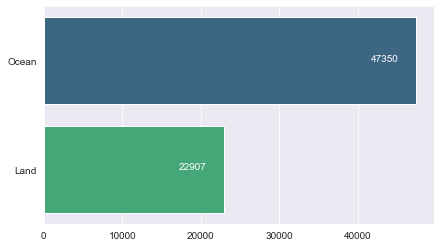

In [7]:
fig, ax = plt.subplots(figsize=(7,4))

ocean_values = train_features['ocean'].value_counts().values

sns.barplot(x=ocean_values,
            y=['Ocean', 'Land'],
            orient='h',
            palette='viridis',
            ax=ax)

for idx, val in enumerate(ocean_values):
    ax.text(x = val - ocean_values.min()*0.25,
            y = idx,
            s = val,
            **dict(size=10, color='white'))
    
plt.show()

### 2.2 Labels

In [8]:
train_labels = pd.read_csv('data/training_set_labels.csv')
train_labels.head()

,image_id,wind_speed
0,abs_000,43
1,abs_001,44
2,abs_002,45
3,abs_003,52
4,abs_004,53


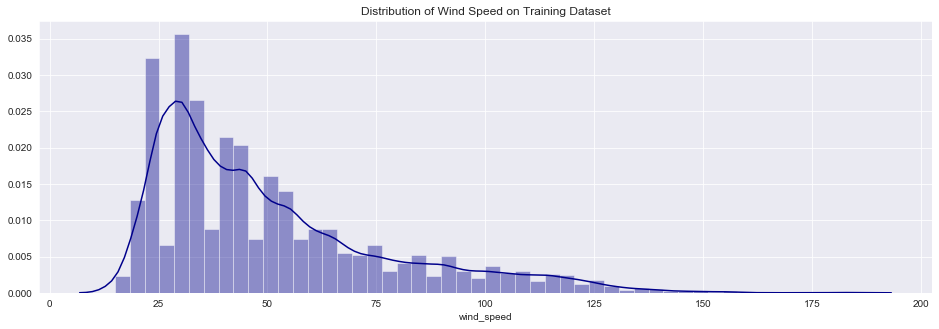

In [9]:
fig, ax = plt.subplots(figsize=(16,5))

plt.title('Distribution of Wind Speed on Training Dataset')
sns.distplot(a=train_labels['wind_speed'],color='darkblue')

plt.show()

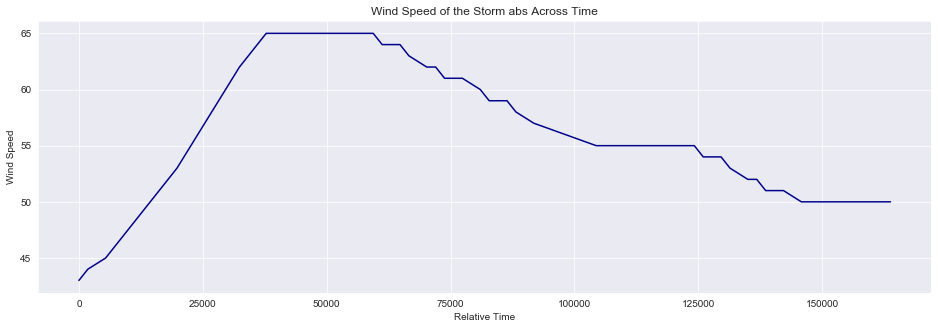

In [10]:
storm_choice = 'abs'

fig, ax = plt.subplots(figsize=(16,5))

time = train_features.loc[train_features['storm_id']==storm_choice]['relative_time'].values
speed = train_labels.loc[train_labels['image_id'].str.contains(storm_choice)]['wind_speed'].values

plt.title('Wind Speed of the Storm {} Across Time'.format(storm_choice))
plt.ylabel('Wind Speed')
plt.xlabel('Relative Time')
sns.lineplot(x=time, y=speed, color='darkblue')

plt.show()


### 2.3 Images

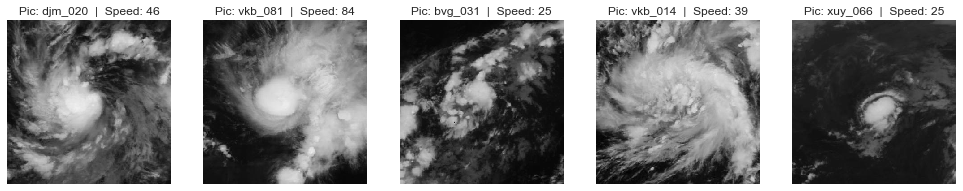

In [11]:
sample_images = []
train_imgs = [file for file in os.listdir(training_dir)]

for idx in np.random.randint(0,len(train_imgs),5):
    sample_images.append(training_dir+'/'+train_imgs[idx])

fig, axes = plt.subplots(1, 5, figsize=(17,8))

for idx,img in enumerate(sample_images):
    image = cv2.imread(img)
    name = img.split('/')[-1][:-4]
    wind_s = train_labels.loc[train_labels['image_id']==name]['wind_speed'].values[0]
    axes[idx].set_title('Pic: {}  |  Speed: {}'.format(name,wind_s))
    axes[idx].imshow(image)
    axes[idx].axis("off")

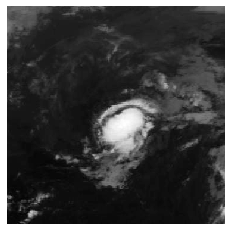

In [12]:
image2 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image2, cmap='gray')
plt.axis("off")
plt.show()

In [13]:
image2.shape

(366, 366)

In [14]:
for dim in range(0,image.shape[2]):
    print('Dimension {}: the maximum is {} and the minimum is {}.'.format(dim, image[dim].max(), image[dim].min()))

Dimension 0: the maximum is 94 and the minimum is 37.
Dimension 1: the maximum is 90 and the minimum is 36.
Dimension 2: the maximum is 90 and the minimum is 35.


In [15]:
if jump_cell == False:
    
    storm_choice = 'rkw'

    img_array = []
    for file in os.listdir(training_dir):
        if storm_choice in file:
            img = cv2.imread(training_dir + '/' + file)
            height, width, layers = img.shape
            size = (width,height)
            img_array.append(img)

    out = cv2.VideoWriter('storm_example.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

In [16]:
if jump_cell == False:
    
    cap = cv2.VideoCapture('storm_example.avi')

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            print("Stream ended")
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        cv2.imshow('Storm {}'.format(storm_choice), gray)

        if cv2.waitKey(50) & 0xff==27:
            break

    cap.release()
    cv2.destroyAllWindows()

<a class="anchor" id="data-preparation"></a>
## 3. Data Preparation

In [17]:
train_labels['storm'] = np.vectorize(lambda s: re.search(r'[a-z]{3}', s).group())(train_labels['image_id'])

train_labels['image_id_jpg'] = np.vectorize(lambda s: s+'.jpg')(train_labels['image_id'])

In [18]:
if jump_cell == True:

    tsh = int(len(train_features)*0.3)

    storm_counts = train_features['storm_id'].value_counts().sample(frac=1)

    sum_pics = 0
    storms_to_val_test = []

    for storm, count in storm_counts.items():
        if sum_pics <= tsh:
            sum_pics += count
            storms_to_val_test.append(storm)
        else:
            break

In [19]:
train_train_labels = train_labels[~train_labels['storm'].isin(storms_to_val_test)]

train_val_test_labels = train_labels[train_labels['storm'].isin(storms_to_val_test)]

In [20]:
if jump_cell == True:

    tsh = int(len(train_val_test_labels)*0.5)

    storm_counts = train_val_test_labels['storm'].value_counts().sample(frac=1)

    sum_pics = 0
    storms_to_val = []

    for storm, count in storm_counts.items():
        if sum_pics <= tsh:
            sum_pics += count
            storms_to_val.append(storm)
        else:
            break

In [21]:
train_val_labels = train_val_test_labels[train_val_test_labels['storm'].isin(storms_to_val)]

train_test_labels = train_val_test_labels[~train_val_test_labels['storm'].isin(storms_to_val)]

In [22]:
sub_labels = pd.read_csv('data/test_set_features.csv')

sub_labels['image_id_jpg'] = np.vectorize(lambda s: s+'.jpg')(sub_labels['image_id'])

In [23]:
datagen = ImageDataGenerator(rescale=1./255)

print('Training Set:')
train_generator = datagen.flow_from_dataframe(dataframe = train_train_labels,
                                              directory = "../image_data/train",
                                              x_col = "image_id_jpg",
                                              y_col = "wind_speed",
                                              class_mode = "raw",
                                              target_size = (32,32),
                                              batch_size = 32,
                                              shuffle = False)
print()

print('Validation Set:')
val_generator = datagen.flow_from_dataframe(dataframe = train_val_labels,
                                              directory = "../image_data/train",
                                              x_col = "image_id_jpg",
                                              y_col = "wind_speed",
                                              class_mode = "raw",
                                              target_size = (32,32),
                                              batch_size = 32,
                                              shuffle = False)
print()

print('Test Set:')
test_generator = datagen.flow_from_dataframe(dataframe = train_test_labels,
                                              directory = "../image_data/train",
                                              x_col = "image_id_jpg",
                                              y_col = "wind_speed",
                                              class_mode = "raw",
                                              target_size = (32,32),
                                              batch_size = 32,
                                              shuffle = False)
print()
print('-------------')
print('Submission Set:')
submission_generator = datagen.flow_from_dataframe(dataframe = sub_labels,
                                              directory = "../image_data/test",
                                              x_col = "image_id_jpg",
                                              y_col = None,
                                              class_mode = None,
                                              target_size = (32,32),
                                              batch_size = 32,
                                              shuffle = False)

Training Set:
Found 48955 validated image filenames.

Validation Set:
Found 10914 validated image filenames.

Test Set:
Found 10388 validated image filenames.

-------------
Submission Set:
Found 44377 validated image filenames.


<a class="anchor" id="modeling"></a>
## 4. Modeling

In [24]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics

In [26]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128
first_dense=256
second_dense=128
dropout_conv = 0.3
dropout_dense = 0.3

#####################


model = Sequential()

# First conv filters
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', padding="same",
                 input_shape = (32,32,3)))
model.add(Conv2D(first_filters, kernel_size, padding="same", activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, padding="same", activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

# Second conv filter
model.add(Conv2D(second_filters, kernel_size, padding="same", activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, padding="same", activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, padding="same", activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

# Third conv filter
model.add(Conv2D(third_filters, kernel_size, padding="same", activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, padding="same", activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, padding="same", activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())

# First dense
model.add(Dense(first_dense, activation = "relu"))
model.add(Dropout(dropout_dense))
# Second dense
model.add(Dense(second_dense, activation = "relu"))
model.add(Dropout(dropout_dense))
# Out layer
model.add(Dense(1, activation='relu'))

#Compiler
model.compile(optimizer=Adam(lr=0.001), loss='mse')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [27]:
early_stop = EarlyStopping(monitor='val_loss', mode='min',
                          verbose=1, patience=25)

In [28]:
with tensorflow.device(selected_device):
    model.fit_generator(generator = train_generator,
                        epochs = 100,
                        steps_per_epoch = 20,
                        validation_data = val_generator,
                        validation_steps=5,
                        callbacks=[early_stop])

Epoch 1/100
20/20 [==============================] - 5s 229ms/step - loss: 2389.2632 - val_loss: 711.3391
Epoch 2/100
20/20 [==============================] - 1s 61ms/step - loss: 1986.0830 - val_loss: 180.9502
Epoch 3/100
20/20 [==============================] - 1s 58ms/step - loss: 650.6913 - val_loss: 1131.0559
Epoch 4/100
20/20 [==============================] - 1s 58ms/step - loss: 1101.1779 - val_loss: 79.0193
Epoch 5/100
20/20 [==============================] - 1s 58ms/step - loss: 1830.9410 - val_loss: 561.7683
Epoch 6/100
20/20 [==============================] - 1s 59ms/step - loss: 604.1104 - val_loss: 60.4081
Epoch 7/100
20/20 [==============================] - 1s 59ms/step - loss: 964.8966 - val_loss: 682.7484
Epoch 8/100
20/20 [==============================] - 1s 58ms/step - loss: 826.3649 - val_loss: 211.2941
Epoch 9/100
20/20 [==============================] - 1s 59ms/step - loss: 1164.0892 - val_loss: 349.2462
Epoch 10/100
20/20 [==============================] - 1s 59

In [29]:
ws_test_true = train_test_labels['wind_speed'].values

ws_test_preds = model.predict_generator(test_generator)
ws_test_preds = ws_test_preds.reshape(-1)

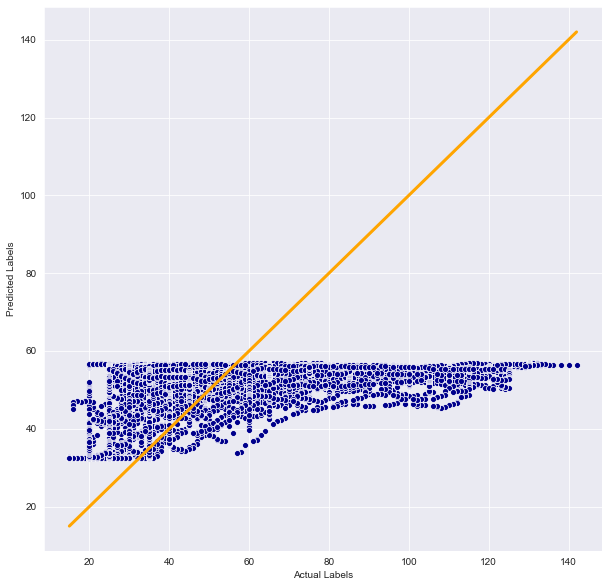

In [30]:
fig, axes = plt.subplots(figsize=(10,10))

sns.scatterplot(x=ws_test_true,
               y=ws_test_preds, ax=axes,
               color='darkblue')
sns.lineplot(x=ws_test_true,
             y=ws_test_true,
             ax=axes,
            color='orange',
            linewidth = 3)

plt.ylabel('Predicted Labels')
plt.xlabel('Actual Labels')

plt.show()

In [31]:
print('Test set\'s RMSE: {}'.format(metrics.mean_squared_error(ws_test_true, ws_test_preds, squared=False)))

Test set's RMSE: 23.79285295949266


In [32]:
with tensorflow.device(selected_device):
    ws_sub_preds = model.predict_generator(submission_generator)
    ws_sub_preds = ws_sub_preds.reshape(-1)

In [33]:
sub_labels['wind_speed'] = ws_sub_preds
sub_labels['wind_speed'] = np.vectorize(lambda ws: int(ws))(sub_labels['wind_speed'])

In [34]:
mov_avg_ison = True

In [37]:
if mov_avg_ison == False:
    
    sub_df = sub_labels[['image_id','wind_speed']]
    sub_df.set_index('image_id', inplace=True)
    
else:
    
    series_mov_avg = []

    for storm in sub_labels['storm_id'].unique():
        lista = sub_labels[sub_labels['storm_id']==storm]['wind_speed'].rolling(window=5, center=True).mean()
        series_mov_avg.append(lista)

    series_mov_avg_flat = [item for sublist in series_mov_avg for item in sublist]

    sub_labels['mov_avg'] = series_mov_avg_flat
    sub_labels['mov_avg'].fillna(sub_labels['wind_speed'], inplace=True)
    sub_labels['mov_avg'] = np.vectorize(lambda ws: int(ws))(sub_labels['mov_avg'])
    
    sub_df = sub_labels[['image_id','mov_avg']]
    sub_df.set_index('image_id', inplace=True)
    sub_df.rename(columns={'mov_avg':'wind_speed'}, inplace=True)

In [39]:
now = datetime.now().strftime("%Y%m%d_%H%M")
sub_df.to_csv('submissions/dfsub_'+now+'.csv')

model.save('models/model_'+now+'.h5')

print('Test set\'s RMSE: {}'.format(metrics.mean_squared_error(ws_test_true, ws_test_preds, squared=False)))

Test set's RMSE: 23.79285295949266


<a class="anchor" id="conclusion"></a>
## 5. Conclusions